In [1]:
import tensorflow as tf
tf.__version__

'2.6.0'

In [2]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [3]:
#!python3 -m pip uninstall tensorflow-gpu -y

In [4]:
#! python3 -m pip install keras==2.6.0

In [5]:
from get_data import *
from metrics import MultipleClassAUROC
from model import *
import tensorflow as tf

In [6]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:4', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:5', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:6', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:7', device_type='GPU')]

In [7]:
DATASET_PATH = os.path.abspath('/data/NIH_14')

In [8]:
data, all_labels = get_data(DATASET_PATH)
train_df, valid_df, test_df = split_train_dev_test(data)
train_gen = get_data_generator(train_df, all_labels)
valid_gen = get_data_generator(valid_df, all_labels)
test_gen = get_data_generator(test_df, all_labels)

Data Shape : (112120, 12)
New dataset dimensions: (112104, 12)
Number of Images: 112120
Dataset Dimension: (112104, 17)
Training: 54091 Validation: 23183 Testing: 33118


/usr/lib/python3/dist-packages/keras_preprocessing/image/dataframe_iterator.py:219: UserWarning: `classes` will be ignored given the class_mode="raw"
  warnings.warn('`classes` will be ignored given the class_mode="{}"'


Found 54091 validated image filenames.
Found 23183 validated image filenames.
Found 33118 validated image filenames.


In [9]:
model = get_model(all_labels)

In [10]:
import tensorflow_model_optimization as tfmot

In [11]:
quantize_annotate_layer = tfmot.quantization.keras.quantize_annotate_layer
quantize_annotate_model = tfmot.quantization.keras.quantize_annotate_model
quantize_scope = tfmot.quantization.keras.quantize_scope

In [12]:
class DefaultBNQuantizeConfig(tfmot.quantization.keras.QuantizeConfig):
    def get_weights_and_quantizers(self, layer):
        return []
    
    def get_activations_and_quantizers(self, layer):
        return []
    
    def set_quantize_weights(self, layer, quantize_weights):
        pass

    def set_quantize_activations(self, layer, quantize_activations):
        pass

    def get_output_quantizers(self, layer):
        return [tfmot.quantization.keras.quantizers.MovingAverageQuantizer(
    num_bits=8, per_axis=False, symmetric=False, narrow_range=False)]

    def get_config(self):
        return {}

In [13]:
def apply_quantization_to_batch_normalization(layer):
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        return quantize_annotate_layer(layer, DefaultBNQuantizeConfig())
    
    return layer

In [14]:
annotated_model = tf.keras.models.clone_model(
                    model,
                    clone_function=apply_quantization_to_batch_normalization,
)

In [15]:
with quantize_scope(
  {'DefaultBNQuantizeConfig': DefaultBNQuantizeConfig}):
  # Use `quantize_apply` to actually make the model quantization aware.
  quant_aware_model = tfmot.quantization.keras.quantize_apply(annotated_model)

In [16]:
quant_aware_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
quant_conv1/conv (QuantizeWrapp (None, 112, 112, 64) 9411        zero_padding2d[1][0]             
__________________________________________________________________________________________________
quant_conv1/bn (QuantizeWrapper (None, 112, 112, 64) 259         quant_conv1/conv[0][0]           
______________________________________________________________________________________________

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint
model_train = quant_aware_model
output_weights_name='FP_32_QAT_weights.h5'
checkpoint = ModelCheckpoint(
             output_weights_name,
             save_weights_only=True,
             save_best_only=True,
             verbose=1,
            )

In [18]:
training_stats = {}
auroc = MultipleClassAUROC(
    generator=valid_gen,
    class_names=all_labels,
    weights_path=output_weights_name,
    stats=training_stats
)

In [19]:
from tensorflow.keras.optimizers import Adam
initial_learning_rate=1e-3
optimizer = Adam(lr=initial_learning_rate)
model_train.compile(optimizer=optimizer, loss="binary_crossentropy")

/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [20]:
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau
logs_base_dir = os.getcwd()
patience_reduce_lr=2
min_lr=1e-8
callbacks = [
            checkpoint,
            TensorBoard(log_dir=os.path.join(logs_base_dir, "logs"), batch_size=train_gen.batch_size),
            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=patience_reduce_lr,
                              verbose=1, mode="min", min_lr=min_lr),
            auroc,
        ]

In [21]:
epochs=20
fit_history = model_train.fit_generator(
    generator=train_gen,
    steps_per_epoch=train_gen.n/train_gen.batch_size,
    epochs=epochs,
    validation_data=valid_gen,
    validation_steps=valid_gen.n/valid_gen.batch_size,
    callbacks=callbacks,
    shuffle=False
)

/usr/local/lib/python3.8/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
1690/1690 [==============================] - 1102s 640ms/step - loss: 0.1665 - val_loss: 0.1870

Epoch 00001: val_loss improved from inf to 0.18702, saving model to FP_32_weights.h5

*********************************
Learning Rate actual: 0.0010000000474974513


/usr/local/lib/python3.8/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


*** epoch#1 ROC Curves Training Phase ***
1. Atelectasis: 0.5840973755126915
2. Cardiomegaly: 0.6230019934529963
3. Consolidation: 0.6396503546219786
4. Edema: 0.8209450624704862
5. Effusion: 0.7928904883617091
6. Emphysema: 0.6651083881407106
7. Fibrosis: 0.5481583715097226
8. Hernia: 0.5570129260075158
9. Infiltration: 0.6429766030366145
10. Mass: 0.6325938299690229
11. Nodule: 0.5853711051409378
12. Pleural_Thickening: 0.5305960667737232
13. Pneumonia: 0.5646740868604366
14. Pneumothorax: 0.6825685809997414
*********************************
Average ROC Curves: 0.6335460880613061
Update of the result of the ROC Curves of: 0 a 0.6335460880613061
Update log files: best_auroc.log
Weight group update FP_32_weights.h5 -> best_FP_32_weights.h5
*********************************
Epoch 2/20
1690/1690 [==============================] - 979s 579ms/step - loss: 0.1597 - val_loss: 0.1640

Epoch 00002: val_loss improved from 0.18702 to 0.16398, saving model to FP_32_weights.h5

*******************

/usr/local/lib/python3.8/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


*** epoch#2 ROC Curves Training Phase ***
1. Atelectasis: 0.7356600272452414
2. Cardiomegaly: 0.7579733326640269
3. Consolidation: 0.7676177576354059
4. Edema: 0.8485885113003756
5. Effusion: 0.8277294095482792
6. Emphysema: 0.7361150505253153
7. Fibrosis: 0.6731152065861344
8. Hernia: 0.7002181331259989
9. Infiltration: 0.6585625675957063
10. Mass: 0.6961921520079007
11. Nodule: 0.6506489346312815
12. Pleural_Thickening: 0.6889172479318291
13. Pneumonia: 0.6974121649519563
14. Pneumothorax: 0.7810540825147262
*********************************
Average ROC Curves: 0.7299860413045841
Update of the result of the ROC Curves of: 0.6335460880613061 a 0.7299860413045841
Update log files: best_auroc.log
Weight group update FP_32_weights.h5 -> best_FP_32_weights.h5
*********************************
Epoch 3/20
1690/1690 [==============================] - 969s 573ms/step - loss: 0.1545 - val_loss: 0.1581

Epoch 00003: val_loss improved from 0.16398 to 0.15808, saving model to FP_32_weights.h5

**

/usr/local/lib/python3.8/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


*** epoch#3 ROC Curves Training Phase ***
1. Atelectasis: 0.7487705200335941
2. Cardiomegaly: 0.8428017557445766
3. Consolidation: 0.780619847180641
4. Edema: 0.8669323143899414
5. Effusion: 0.8473369000060821
6. Emphysema: 0.7622076902923314
7. Fibrosis: 0.7006693669973025
8. Hernia: 0.7260283033130318
9. Infiltration: 0.6653025554457176
10. Mass: 0.7164089532849183
11. Nodule: 0.6570831943452157
12. Pleural_Thickening: 0.7077963246236
13. Pneumonia: 0.7171034506190759
14. Pneumothorax: 0.8070957984401317
*********************************
Average ROC Curves: 0.75329692676544
Update of the result of the ROC Curves of: 0.7299860413045841 a 0.75329692676544
Update log files: best_auroc.log
Weight group update FP_32_weights.h5 -> best_FP_32_weights.h5
*********************************
Epoch 4/20
1690/1690 [==============================] - 970s 574ms/step - loss: 0.1516 - val_loss: 0.1554

Epoch 00004: val_loss improved from 0.15808 to 0.15543, saving model to FP_32_weights.h5

**********

/usr/local/lib/python3.8/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


*** epoch#4 ROC Curves Training Phase ***
1. Atelectasis: 0.7641854096191669
2. Cardiomegaly: 0.8727518313988804
3. Consolidation: 0.784493500181427
4. Edema: 0.87307927477419
5. Effusion: 0.8573589419991664
6. Emphysema: 0.7889306215499822
7. Fibrosis: 0.6915257405725955
8. Hernia: 0.7802767699019479
9. Infiltration: 0.6745872138902105
10. Mass: 0.7466694528712028
11. Nodule: 0.6719981389580056
12. Pleural_Thickening: 0.7115120813172943
13. Pneumonia: 0.7316743335600902
14. Pneumothorax: 0.8168359005524275
*********************************
Average ROC Curves: 0.7689913722247562
Update of the result of the ROC Curves of: 0.75329692676544 a 0.7689913722247562
Update log files: best_auroc.log
Weight group update FP_32_weights.h5 -> best_FP_32_weights.h5
*********************************
Epoch 5/20
1690/1690 [==============================] - 975s 577ms/step - loss: 0.1491 - val_loss: 0.1553

Epoch 00005: val_loss improved from 0.15543 to 0.15534, saving model to FP_32_weights.h5

*******

/usr/local/lib/python3.8/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


*** epoch#5 ROC Curves Training Phase ***
1. Atelectasis: 0.7674824335178401
2. Cardiomegaly: 0.878623776663545
3. Consolidation: 0.7874524841337356
4. Edema: 0.8736013515674531
5. Effusion: 0.8559636042877211
6. Emphysema: 0.8108889606704851
7. Fibrosis: 0.7136045659367014
8. Hernia: 0.8141602954516004
9. Infiltration: 0.6787455918070818
10. Mass: 0.7603552811221365
11. Nodule: 0.6805509819605885
12. Pleural_Thickening: 0.7211521722122324
13. Pneumonia: 0.733054725221642
14. Pneumothorax: 0.818532878175832
*********************************
Average ROC Curves: 0.7781549359091854
Update of the result of the ROC Curves of: 0.7689913722247562 a 0.7781549359091854
Update log files: best_auroc.log
Weight group update FP_32_weights.h5 -> best_FP_32_weights.h5
*********************************
Epoch 6/20
1690/1690 [==============================] - 977s 578ms/step - loss: 0.1472 - val_loss: 0.1541

Epoch 00006: val_loss improved from 0.15534 to 0.15412, saving model to FP_32_weights.h5

*****

/usr/local/lib/python3.8/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


*** epoch#6 ROC Curves Training Phase ***
1. Atelectasis: 0.7710726270846011
2. Cardiomegaly: 0.8812284076725542
3. Consolidation: 0.7822716012376677
4. Edema: 0.8848085059949468
5. Effusion: 0.8601913483091064
6. Emphysema: 0.819943818779733
7. Fibrosis: 0.7046645351699601
8. Hernia: 0.8193423070277742
9. Infiltration: 0.6784323199472876
10. Mass: 0.731496461604542
11. Nodule: 0.6866930995871099
12. Pleural_Thickening: 0.7243909669386246
13. Pneumonia: 0.730095160328923
14. Pneumothorax: 0.8261831712602608
*********************************
Average ROC Curves: 0.7786295950673637
Update of the result of the ROC Curves of: 0.7781549359091854 a 0.7786295950673637
Update log files: best_auroc.log
Weight group update FP_32_weights.h5 -> best_FP_32_weights.h5
*********************************
Epoch 7/20
1458/1690 [========================>.....] - ETA: 1:34 - loss: 0.1456

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



*** epoch#9 ROC Curves Training Phase ***
1. Atelectasis: 0.7613150958312506
2. Cardiomegaly: 0.8904670173902933
3. Consolidation: 0.7874210074637884
4. Edema: 0.8842339393186852
5. Effusion: 0.8591632442579931
6. Emphysema: 0.8258602571968885
7. Fibrosis: 0.7360903843092793
8. Hernia: 0.8556879292471167
9. Infiltration: 0.6790564141782862
10. Mass: 0.7562688548277843
11. Nodule: 0.6846598738226957
12. Pleural_Thickening: 0.7288278003047288
13. Pneumonia: 0.7454595076495358
14. Pneumothorax: 0.8349082168395124
*********************************
Average ROC Curves: 0.7878156816169885
Update of the result of the ROC Curves of: 0.7862347594858187 a 0.7878156816169885
Update log files: best_auroc.log
Weight group update FP_32_weights.h5 -> best_FP_32_weights.h5
*********************************
Epoch 10/20
1690/1690 [==============================] - 976s 577ms/step - loss: 0.1380 - val_loss: 0.1559

Epoch 00010: val_loss did not improve from 0.15046

Epoch 00010: ReduceLROnPlateau reducing

/usr/local/lib/python3.8/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


*** epoch#10 ROC Curves Training Phase ***
1. Atelectasis: 0.7499977144667513
2. Cardiomegaly: 0.887204888517749
3. Consolidation: 0.7814985139977889
4. Edema: 0.8779680300866742
5. Effusion: 0.8535021865835151
6. Emphysema: 0.791832011197929
7. Fibrosis: 0.7021511203313798
8. Hernia: 0.8276532331216794
9. Infiltration: 0.6736033797531341
10. Mass: 0.7654655638186261
11. Nodule: 0.6495945069352655
12. Pleural_Thickening: 0.7234130005025914
13. Pneumonia: 0.733605737022601
14. Pneumothorax: 0.8274170604438389
*********************************
Average ROC Curves: 0.7746362104842517
Epoch 11/20
1690/1690 [==============================] - 971s 574ms/step - loss: 0.1317 - val_loss: 0.1508

Epoch 00011: val_loss did not improve from 0.15046

*********************************
Learning Rate actual: 0.00010000000474974513


/usr/local/lib/python3.8/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


*** epoch#11 ROC Curves Training Phase ***
1. Atelectasis: 0.7695665870627021
2. Cardiomegaly: 0.8755987374507191
3. Consolidation: 0.7717939153397417
4. Edema: 0.8652355177778905
5. Effusion: 0.8557571379194229
6. Emphysema: 0.8214221855864092
7. Fibrosis: 0.7234016815414888
8. Hernia: 0.8663921104919874
9. Infiltration: 0.6812640797983229
10. Mass: 0.7864939051248881
11. Nodule: 0.7014176826151273
12. Pleural_Thickening: 0.7467646569198525
13. Pneumonia: 0.7159979185640012
14. Pneumothorax: 0.8338181969504663
*********************************
Average ROC Curves: 0.7867803080816443
Epoch 12/20
1690/1690 [==============================] - 974s 576ms/step - loss: 0.1280 - val_loss: 0.1530

Epoch 00012: val_loss did not improve from 0.15046

Epoch 00012: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

*********************************
Learning Rate actual: 1.0000000656873453e-05


/usr/local/lib/python3.8/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


*** epoch#12 ROC Curves Training Phase ***
1. Atelectasis: 0.760126913449489
2. Cardiomegaly: 0.868030954035544
3. Consolidation: 0.7615704446356474
4. Edema: 0.8529919233309065
5. Effusion: 0.8510302921180637
6. Emphysema: 0.8116548182686881
7. Fibrosis: 0.7162987049729694
8. Hernia: 0.8589032331216794
9. Infiltration: 0.6769291613941371
10. Mass: 0.7794348599289413
11. Nodule: 0.6960314988529475
12. Pleural_Thickening: 0.7393288190561343
13. Pneumonia: 0.7088859147054414
14. Pneumothorax: 0.8294653457623433
*********************************
Average ROC Curves: 0.7793344916880666
Epoch 13/20
1690/1690 [==============================] - 972s 575ms/step - loss: 0.1258 - val_loss: 0.1477

Epoch 00013: val_loss improved from 0.15046 to 0.14766, saving model to FP_32_weights.h5

*********************************
Learning Rate actual: 1.0000000656873453e-05


/usr/local/lib/python3.8/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


*** epoch#13 ROC Curves Training Phase ***
1. Atelectasis: 0.7855891441173007
2. Cardiomegaly: 0.8979914004560696
3. Consolidation: 0.7933827898816739
4. Edema: 0.8913462243970718
5. Effusion: 0.8710079738351696
6. Emphysema: 0.8589106711147604
7. Fibrosis: 0.7455471382118378
8. Hernia: 0.916910986566455
9. Infiltration: 0.6954734514707452
10. Mass: 0.8078472333747682
11. Nodule: 0.7061653920960344
12. Pleural_Thickening: 0.7655590294192933
13. Pneumonia: 0.745575748242265
14. Pneumothorax: 0.8601706201111123
*********************************
Average ROC Curves: 0.8101055573781828
Update of the result of the ROC Curves of: 0.7878156816169885 a 0.8101055573781828
Update log files: best_auroc.log
Weight group update FP_32_weights.h5 -> best_FP_32_weights.h5
*********************************
Epoch 14/20
1690/1690 [==============================] - 970s 574ms/step - loss: 0.1250 - val_loss: 0.1479

Epoch 00014: val_loss did not improve from 0.14766

*********************************
Learni

/usr/local/lib/python3.8/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


*** epoch#14 ROC Curves Training Phase ***
1. Atelectasis: 0.7844310949642224
2. Cardiomegaly: 0.8990197621486554
3. Consolidation: 0.7927959332850337
4. Edema: 0.8889375219883693
5. Effusion: 0.8709048658158671
6. Emphysema: 0.8572951417399751
7. Fibrosis: 0.7446960687000496
8. Hernia: 0.9115602457777202
9. Infiltration: 0.6948124901380175
10. Mass: 0.8065871818573827
11. Nodule: 0.710066259565002
12. Pleural_Thickening: 0.7654301282853919
13. Pneumonia: 0.7419887242008667
14. Pneumothorax: 0.8594672841359343
*********************************
Average ROC Curves: 0.8091423359001777
Epoch 15/20
1304/1690 [======================>.......] - ETA: 2:36 - loss: 0.1270

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



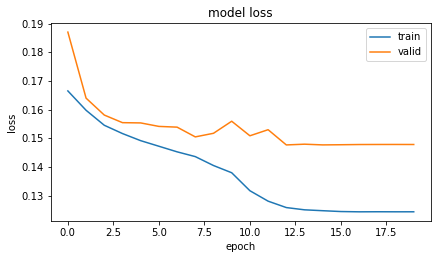

In [22]:
import matplotlib.pyplot as plt

plt.figure(1, figsize = (15,8)) 
    
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

In [23]:
pred_y = model_train.predict_generator(test_gen, steps=test_gen.n/test_gen.batch_size, verbose = True)

/usr/local/lib/python3.8/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


1034/1034 [==============================] - 463s 447ms/step


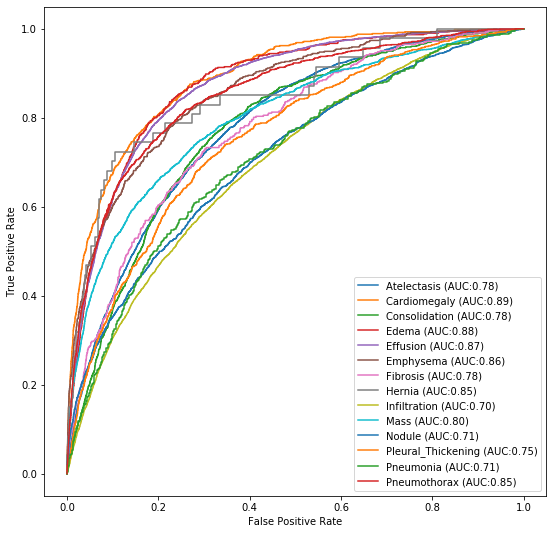

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
test_gen.reset()
test_x, test_y = next(test_gen)
# Space
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    #Points to graph
    fpr, tpr, thresholds = roc_curve(test_gen.labels[:,idx].astype(int), pred_y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    
#convention
c_ax.legend()

#Labels
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')

# Save as a png
fig.savefig('QAT_FP32.png')